# Relationship to MUA
<p>Figures: schematic MUA, epoch-based linear regression of correlation with aperiodic parameters, temporal correlation
<p>
<p>created: Septermber 18, 2024
<p>last modified: September 23, 2024


## Set-up

In [ ]:
# auto-reload
%load_ext autoreload
%autoreload 2

In [52]:
# general
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.stats import zscore

# custom
import sys
sys.path.append("../../code")
from paths import PROJECT_PATH, EXTERNAL_PATH
from info import SESSIONS, FS, TOTAL_CHANS, EPOCH_TIMES
from settings import SPECPARAM_SETTINGS, FREQS, BANDS
from plots import plot_schematic, plot_regression
from utils import compute_confidence_interval, subtract_baseline

### Settings

In [ ]:
# set plotting style
plt.style.use('../../mpl_styles/sfn_2024.mplstyle')


### Create output directory

In [ ]:
dir_out = f"{EXTERNAL_PATH}/figures/sfn_2024"
if not os.path.exists(dir_out):
    os.makedirs(dir_out)

#### load data

In [36]:
# load spectral parameters
params = pd.read_csv(fR"{EXTERNAL_PATH}\data\results\lfp_spectral_params.csv", index_col=0)

## Main

In [18]:
# import rcParams to set figure title font type - TEMP
from matplotlib import rcParams
rcParams['axes.titlesize'] = 36

session = SESSIONS[1]

warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> in odML document section <odML>  (line 5)
Validation found 0 errors and 1 warnings in 0 Sections and 1 Properties.
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> inside <odML> tag
 (line 5)
warning[None:5:<{http://www.w3.org/1999/xsl/transform}stylesheet>]: Invalid element <{http://www.w3.org/1999/xsl/transform}stylesheet> in odML document section <odML>  (line 5)


starting var : offset
subtracting baseline
starting var : exponent
subtracting baseline
starting var : mua
subtracting baseline


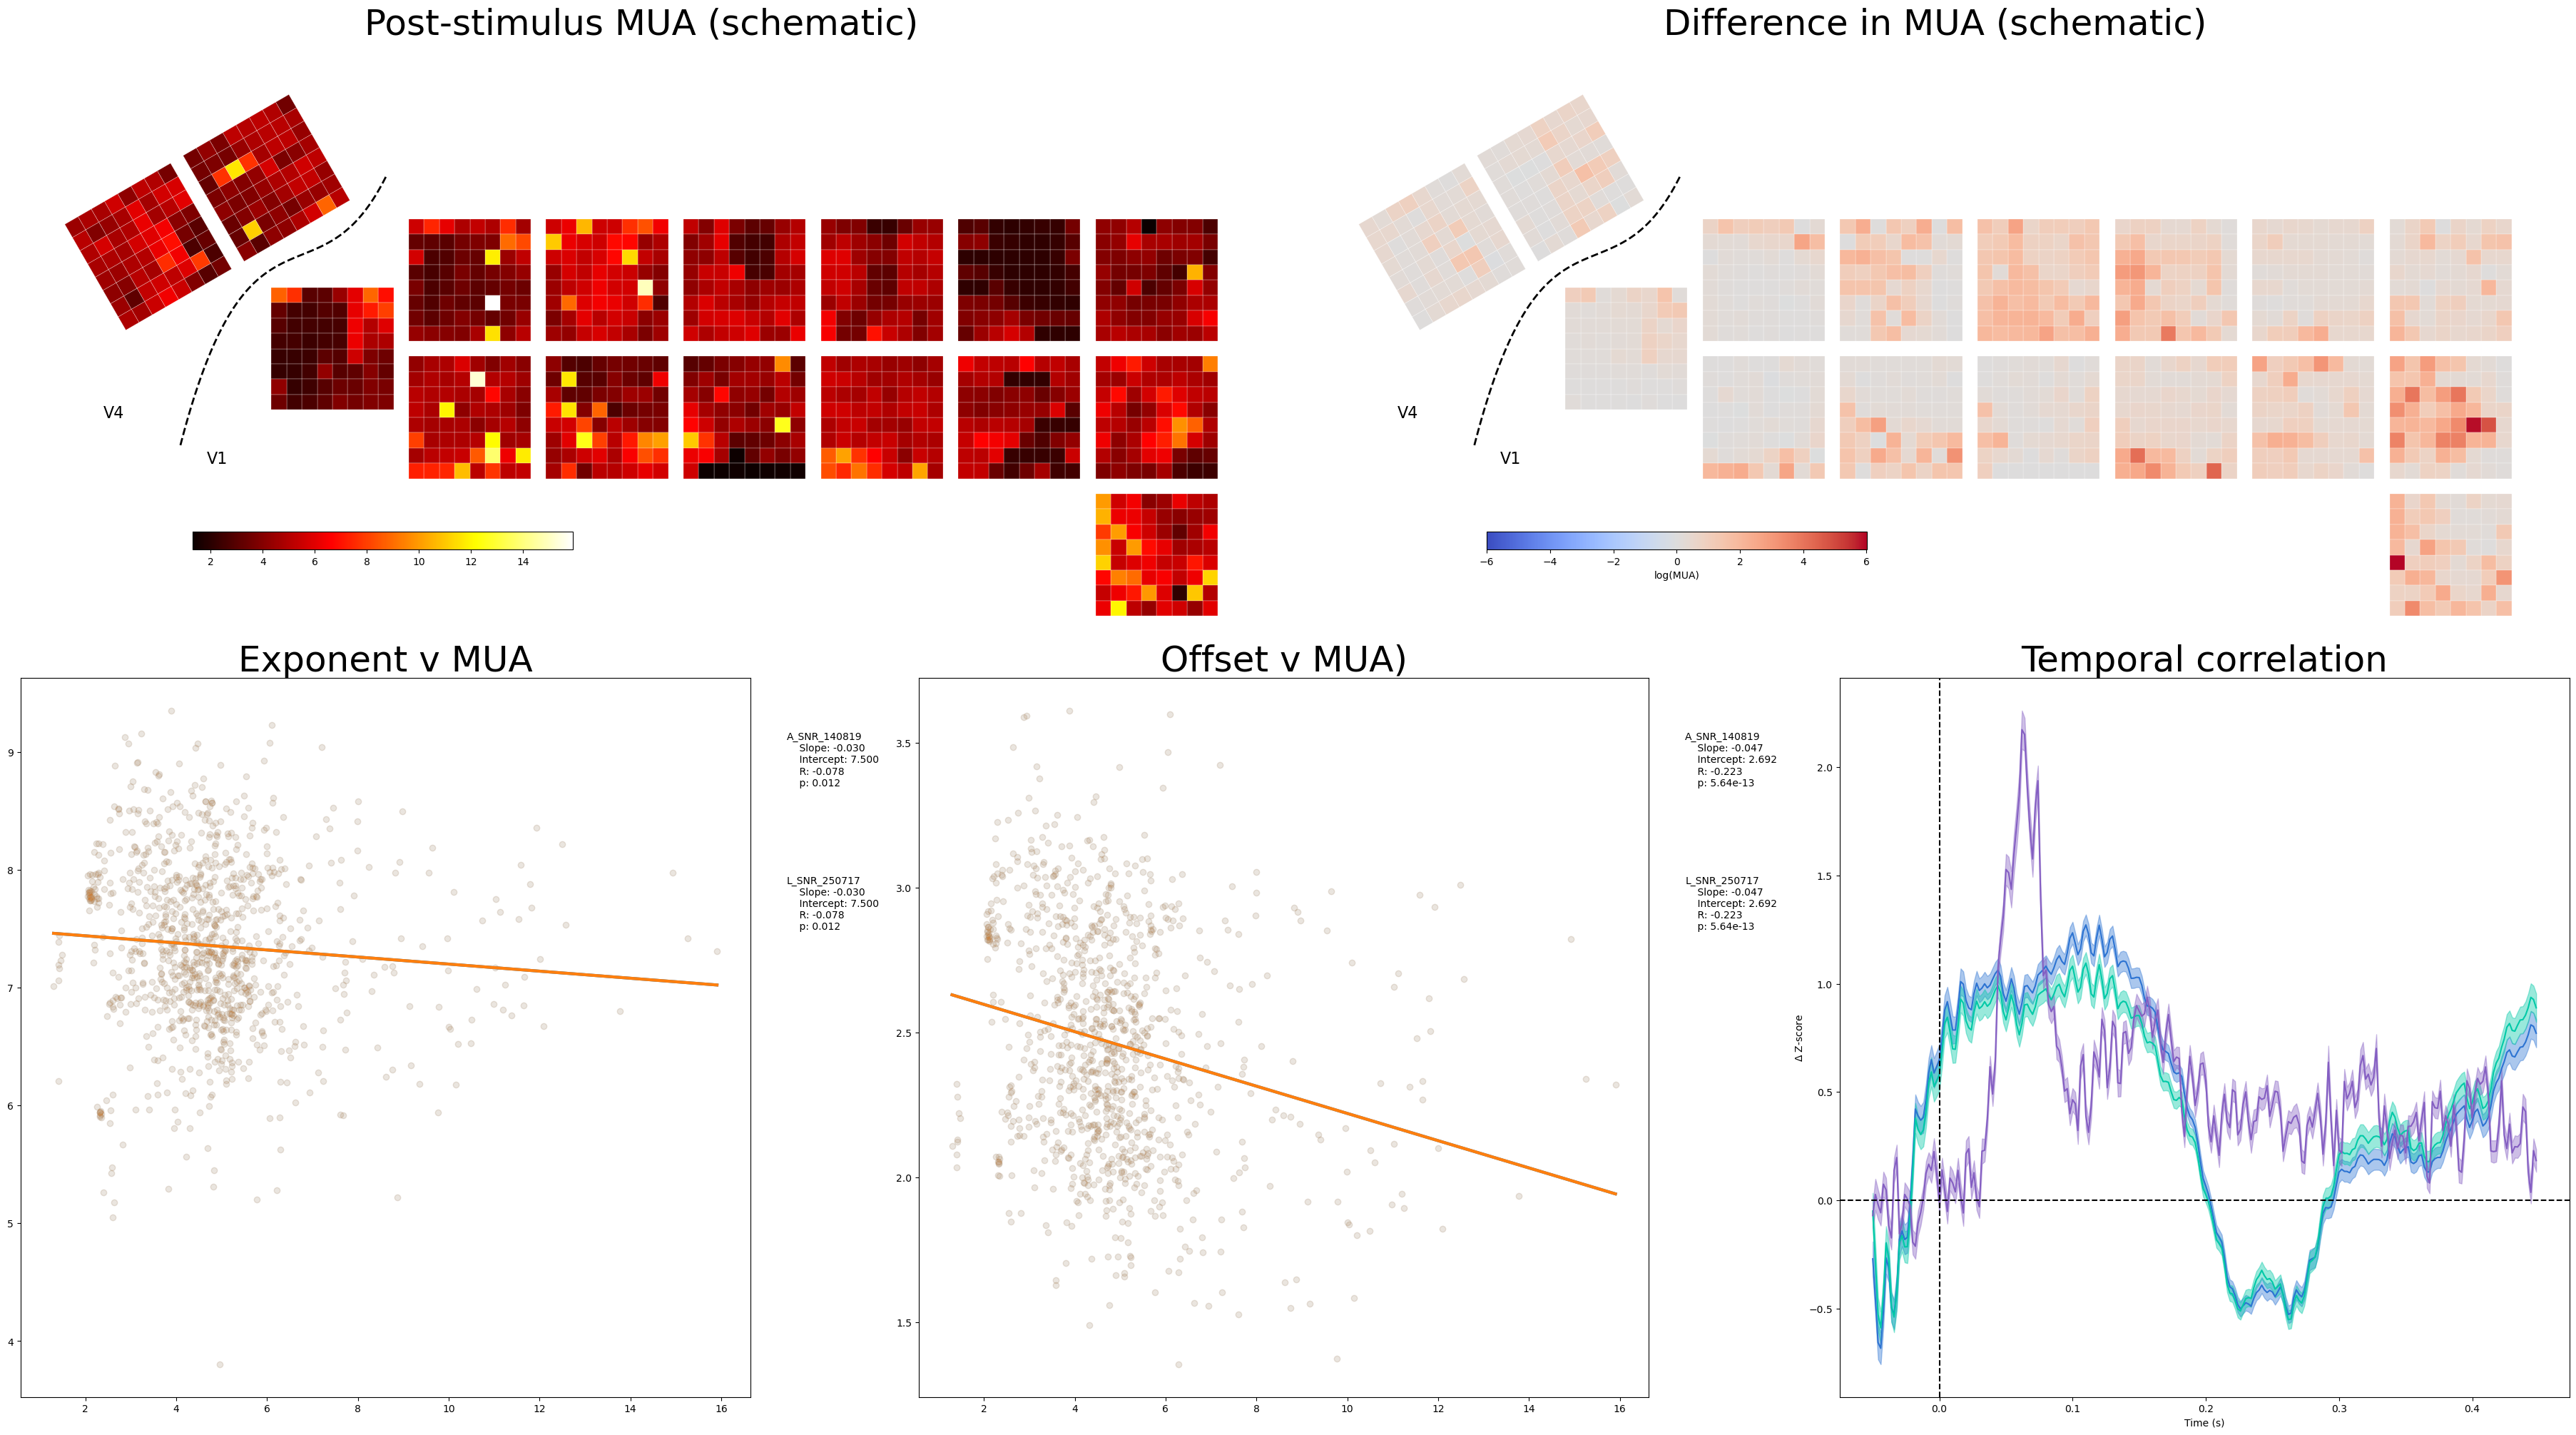

In [56]:
# create figure and gridspec
fig = plt.figure(figsize=[36, 20], constrained_layout=True)
spec = gridspec.GridSpec(figure=fig, ncols=2, nrows=2, width_ratios=[1,1], 
                         height_ratios=[3/4,1])

# create subplots (first row)
ax_a = fig.add_subplot(spec[0,0])
ax_b = fig.add_subplot(spec[0,1])

# create nested gridspec in second row
spec_a = spec[1,:].subgridspec(ncols=3, nrows=1, width_ratios=[1,1,1])
ax_c = fig.add_subplot(spec_a[0,0])
ax_d = fig.add_subplot(spec_a[0,1])
ax_e = fig.add_subplot(spec_a[0,2])

# set PLACEHOLDER titles
ax_a.set_title("Post-stimulus MUA (schematic)")
ax_b.set_title("Difference in MUA (schematic)")
ax_c.set_title("Exponent v MUA")
ax_d.set_title("Offset v MUA)")
ax_e.set_title("Temporal correlation")

# plot subplot a-b: schematic ------------
odml_path = f"{EXTERNAL_PATH}/V1_v4_1024_electrode_resting_state_data/data/{session}/metadata_{session}.odml"

mua = pd.read_csv(fr"{EXTERNAL_PATH}\data\results\mua_df.csv")
mua_pre = mua.loc[(mua['session'] == session) &
                (mua['epoch'] == 'pre'), 'mua']
mua_post = mua.loc[(mua['session'] == session) &
                (mua['epoch'] == 'post'), 'mua']
plot_schematic(mua_post, odml_path, ax=ax_a)

diff = mua_post.values - mua_pre.values
plot_schematic(diff, odml_path, norm_type='centered', ax=ax_b)

# plot subplot c-d: epoch-based correlation ------------
mua_params = pd.merge(left=params[params['session'] == session], right=mua[mua['session'] == session], on=['session', 'array', 'channel', 'epoch'])
#post = mua_params[mua_params['epoch'] == 'post']
#ax_c.scatter(np.log(post['mua']), post['exponent'])
for var, ax_lin in zip(['offset', 'exponent'],
                        [ax_c, ax_d]):
    for i_session, session in enumerate(SESSIONS):
        x_data = mua_params.loc[mua_params['epoch'] == 'post', 'mua']
        y_data = mua_params.loc[mua_params['epoch'] == 'post', var]

        if i_session == 0:
            plot_regression(x_data, y_data, ax=ax_lin, xlabel='log(MUA)', ylabel=f'LFP {var}', label=session, label_offset=0.2*i_session)
        else:    
            #ax = plt.gca()
            plot_regression(x_data, y_data, ax=ax_lin, xlabel='log(MUA)', ylabel=f'LFP {var}', label=session, label_offset=0.2*i_session)

# plot subplot e: temporal correlation ------------
data_mua = pd.read_csv(f"{EXTERNAL_PATH}/data/results/lfp_stm_params_mua.csv")
session_df_mua = data_mua[data_mua.get('session') == SESSIONS[0]].loc[((data_mua['window']>124) & (data_mua['window']<375))]
session_df_mua['time'] = (session_df_mua.get('window')/FS) + EPOCH_TIMES[0]

vars = ['offset', 'exponent', 'mua']
ci = {'lci_offset':[], 'rci_offset':[], 'lci_exponent':[], 'rci_exponent':[], 'lci_mua':[], 'rci_mua':[]}

for var in vars:
    print(f'starting var : {var}')
    count = 0
    z_vars = np.array([])

    for i in range(TOTAL_CHANS):
        # channel zscore values
        data_a = session_df_mua.iloc[np.arange(count, count + 250)]

        z_var = zscore(data_a[var], nan_policy='omit')
        z_vars = np.append(z_vars, z_var)

        count = count + 250

    # add zscore and time variables to df
    session_df_mua[f"z_{var}"] = z_vars
    
    # subtract baseline
    print('subtracting baseline')
    session_df_mua[f'relative_{var}'] = subtract_baseline(session_df_mua.get(f'z_{var}'), session_df_mua.get('time'), np.array([session_df_mua.get('time').min(), 0]))

    # compute left and right endpoint confidence intervals
    lci_var = np.array([])
    rci_var = np.array([])

    for i in np.unique(session_df_mua.get('window')):
        window_df = session_df_mua[session_df_mua.get('window') == i]

        ci_var = compute_confidence_interval(window_df.get(f'relative_{var}'))
        ci[f'lci_{var}'].append(ci_var[0])
        ci[f'rci_{var}'].append(ci_var[1])
        
# average components per window
session_df_mua = session_df_mua.groupby('window').mean().reset_index()

# plot variables
ax_e.plot(session_df_mua.get('time'), session_df_mua.get('relative_offset'), c='#2C73D2', label='offset')
ax_e.fill_between(session_df_mua.get('time'), ci.get('lci_offset'), ci.get('rci_offset'), color='#2C73D2', alpha=0.4)

ax_e.plot(session_df_mua.get('time'), session_df_mua.get('relative_exponent'), c='#00C9A7', label='exponent')
ax_e.fill_between(session_df_mua.get('time'), ci.get('lci_exponent'), ci.get('rci_exponent'),  color='#00C9A7', alpha=0.4)

ax_e.plot(session_df_mua.get('time'), session_df_mua.get('relative_mua'), c='#845EC2', label='mua')
ax_e.fill_between(session_df_mua.get('time'), ci.get('lci_mua'), ci.get('rci_mua'),  color='#845EC2', alpha=0.4)
ax_e.set_xlabel('Time (s)')
ax_e.set_ylabel(r'$\Delta$ Z-score')
ax_e.axhline(y=0, color='k', linestyle='--')
ax_e.axvline(x=0, color='k', linestyle='--')

# save figure
plt.savefig(f'{dir_out}/panel_7.png')

In [21]:
data = np.load(f"{EXTERNAL_PATH}/data/lfp/lfp_psd/{session}_spectra.npz")
spectra_pre = np.nanmean(data['spectra_pre'], axis=0)
spectra_post = np.nanmean(data['spectra_post'], axis=0)

spectra_post.shape

(1024, 76)

In [30]:
mua = pd.read_csv(fr"{EXTERNAL_PATH}\data\results\mua_df.csv")
mua_pre = mua.loc[(mua['session'] == session) &
            (mua['epoch'] == 'pre'), 'mua']

In [40]:
mua[mua['session'] == session]

,Unnamed: 0,session,array,channel,epoch,mua
4096,4096,L_SNR_250717,1,0,pre,3.088518
4097,4097,L_SNR_250717,1,1,pre,3.390528
4098,4098,L_SNR_250717,1,2,pre,4.630248
4099,4099,L_SNR_250717,1,3,pre,2.668710
4100,4100,L_SNR_250717,1,4,pre,2.744893
...,...,...,...,...,...,...
6139,6139,L_SNR_250717,16,59,post,5.921929
6140,6140,L_SNR_250717,16,60,post,5.528276
6141,6141,L_SNR_250717,16,61,post,5.299164
6142,6142,L_SNR_250717,16,62,post,4.856267


In [39]:
params[params['session'] == session]

,session,channel,chan_idx,array,epoch,offset,knee,exponent,alpha_cf,alpha_pw,alpha_bw,beta_cf,beta_pw,beta_bw,gamma_cf,gamma_pw,gamma_bw,error,r_squared
2048,L_SNR_250717,0,0,1,pre,5.873746,14.397914,2.218921,NaN,NaN,NaN,16.795079,0.579788,8.688031,60.167532,0.610620,2.970807,0.071503,0.989732
2049,L_SNR_250717,1,1,1,pre,4.216024,-2.668693,1.372939,NaN,NaN,NaN,18.659349,0.517371,10.851295,49.959438,2.886079,5.252956,0.062138,0.987313
2050,L_SNR_250717,2,2,1,pre,6.149756,5.800469,2.288616,NaN,NaN,NaN,19.738945,0.549729,12.000000,60.290280,0.506805,2.213797,0.076278,0.990111
2051,L_SNR_250717,3,3,1,pre,5.672987,-3.449360,1.994846,NaN,NaN,NaN,17.164301,0.588768,8.591352,60.384151,0.355661,2.000000,0.064712,0.989888
2052,L_SNR_250717,4,4,1,pre,5.833075,-0.063454,2.141445,NaN,NaN,NaN,17.268575,0.522411,8.605858,60.707753,0.412702,2.000000,0.070709,0.990577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,L_SNR_250717,59,1019,16,post,6.597218,-4.360148,1.914368,NaN,NaN,NaN,17.007503,0.306629,4.252543,58.515674,0.536050,2.157331,0.077426,0.984753
4092,L_SNR_250717,60,1020,16,post,7.235486,25.438139,2.209834,NaN,NaN,NaN,24.249733,0.229140,2.187178,58.665548,0.454112,2.211706,0.067791,0.986501
4093,L_SNR_250717,61,1021,16,post,7.419636,29.715929,2.295010,NaN,NaN,NaN,23.629867,0.242662,3.318244,58.638905,0.432759,2.142921,0.072445,0.988839
4094,L_SNR_250717,62,1022,16,post,7.256606,15.471685,2.214591,NaN,NaN,NaN,25.983614,0.255546,11.720273,58.680252,0.466644,2.000000,0.073304,0.987195


In [41]:
mua_params = pd.merge(left=params[params['session'] == session], right=mua[mua['session'] == session], on=['session', 'array', 'channel', 'epoch'])

In [42]:
mua_params

,session,channel,chan_idx,array,epoch,offset,knee,exponent,alpha_cf,alpha_pw,...,beta_cf,beta_pw,beta_bw,gamma_cf,gamma_pw,gamma_bw,error,r_squared,Unnamed: 0,mua
0,L_SNR_250717,0,0,1,pre,5.873746,14.397914,2.218921,NaN,NaN,...,16.795079,0.579788,8.688031,60.167532,0.610620,2.970807,0.071503,0.989732,4096,3.088518
1,L_SNR_250717,1,1,1,pre,4.216024,-2.668693,1.372939,NaN,NaN,...,18.659349,0.517371,10.851295,49.959438,2.886079,5.252956,0.062138,0.987313,4097,3.390528
2,L_SNR_250717,2,2,1,pre,6.149756,5.800469,2.288616,NaN,NaN,...,19.738945,0.549729,12.000000,60.290280,0.506805,2.213797,0.076278,0.990111,4098,4.630248
3,L_SNR_250717,3,3,1,pre,5.672987,-3.449360,1.994846,NaN,NaN,...,17.164301,0.588768,8.591352,60.384151,0.355661,2.000000,0.064712,0.989888,4099,2.668710
4,L_SNR_250717,4,4,1,pre,5.833075,-0.063454,2.141445,NaN,NaN,...,17.268575,0.522411,8.605858,60.707753,0.412702,2.000000,0.070709,0.990577,4100,2.744893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,L_SNR_250717,59,1019,16,post,6.597218,-4.360148,1.914368,NaN,NaN,...,17.007503,0.306629,4.252543,58.515674,0.536050,2.157331,0.077426,0.984753,6139,5.921929
2044,L_SNR_250717,60,1020,16,post,7.235486,25.438139,2.209834,NaN,NaN,...,24.249733,0.229140,2.187178,58.665548,0.454112,2.211706,0.067791,0.986501,6140,5.528276
2045,L_SNR_250717,61,1021,16,post,7.419636,29.715929,2.295010,NaN,NaN,...,23.629867,0.242662,3.318244,58.638905,0.432759,2.142921,0.072445,0.988839,6141,5.299164
2046,L_SNR_250717,62,1022,16,post,7.256606,15.471685,2.214591,NaN,NaN,...,25.983614,0.255546,11.720273,58.680252,0.466644,2.000000,0.073304,0.987195,6142,4.856267
